# Análise Exploratória dos Dados

In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from dython.nominal import associations

In [2]:
# warnings are ignored to avoid cluttering the output
import warnings
warnings.filterwarnings("ignore")

In [3]:
url = "https://vincentarelbundock.github.io/Rdatasets/csv/AER/RecreationDemand.csv"
df = pd.read_csv(url)
df = df.drop(columns=["rownames"])

df.head()

,trips,quality,ski,income,userfee,costC,costS,costH
0,0,0,yes,4,no,67.59,68.620,76.800
1,0,0,no,9,no,68.86,70.936,84.780
2,0,0,yes,5,no,58.12,59.465,72.110
3,0,0,no,2,no,15.79,13.750,23.680
4,0,0,yes,3,no,24.02,34.033,34.547


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659 entries, 0 to 658
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   trips    659 non-null    int64  
 1   quality  659 non-null    int64  
 2   ski      659 non-null    object 
 3   income   659 non-null    int64  
 4   userfee  659 non-null    object 
 5   costC    659 non-null    float64
 6   costS    659 non-null    float64
 7   costH    659 non-null    float64
dtypes: float64(3), int64(3), object(2)
memory usage: 41.3+ KB


In [5]:
df.describe()

,trips,quality,income,costC,costS,costH
count,659.000000,659.000000,659.000000,659.000000,659.000000,659.000000
mean,2.244310,1.418816,3.852807,55.423704,59.928053,55.990303
std,6.292475,1.811986,1.851937,46.682648,46.376676,46.133211
min,0.000000,0.000000,1.000000,4.340000,4.767000,5.700000
25%,0.000000,0.000000,3.000000,28.240000,33.312000,28.963500
50%,0.000000,0.000000,3.000000,41.190000,47.000000,42.380000
75%,2.000000,3.000000,5.000000,69.675000,72.573500,68.560000
max,88.000000,5.000000,9.000000,493.770000,491.547000,491.049000


O dataset possui 659 observações e 8 variáveis. Não há valores `null`, o que facilita a análise.

## Transformações

As variáveis `ski` e `userfee` são categóricas no R. Vamos convertê-las para o tipo `category` no pandas:

In [6]:
df['ski'] = df['ski'].astype('category')
df['userfee'] = df['userfee'].astype('category')

## Análises

Primeiro, vamos analisar a variável `trips`:

In [7]:
# Média e Variância
media = df['trips'].mean()
variancia = df['trips'].var()

print(f"Média: {media:.2f}")
print(f"Variância: {variancia:.2f}")
print(f"Valor mínimo: {df['trips'].min()}")
print(f"Valor máximo: {df['trips'].max()}")

Média: 2.24
Variância: 39.60
Valor mínimo: 0
Valor máximo: 88


A variância ($39.6$) é significantemente maior que a média ($2.24$), um indício de sobredispersão.

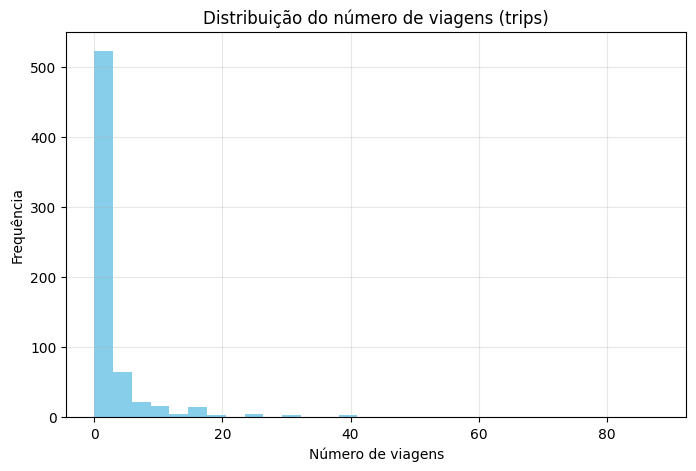

In [8]:
#Histograma Trips
plt.figure(figsize=(8, 5))
plt.hist(df['trips'], bins=30, color='skyblue')
plt.title('Distribuição do número de viagens (trips)')
plt.xlabel('Número de viagens')
plt.ylabel('Frequência')
plt.grid(alpha=0.3)
plt.show()

# save image
#plt.savefig('./images/trips_histogram.png')

In [9]:
# Proporção de zeros
proporcao_zeros = (df['trips'] == 0).mean()
print(f"Proporção de zeros: {proporcao_zeros:.2%}")

Proporção de zeros: 63.28%


Observando o histograma vemos que a distribuição é assimétrica à direita (muitos valores baixos), com acúmulo importante no zero ($63.3\%$ das observações). Essa é uma característica típica de dados de contagem, e reforça a necessidade de investigar a adequação do modelo de Poisson.

Vamos observar também a distribuição das outras variáveis:

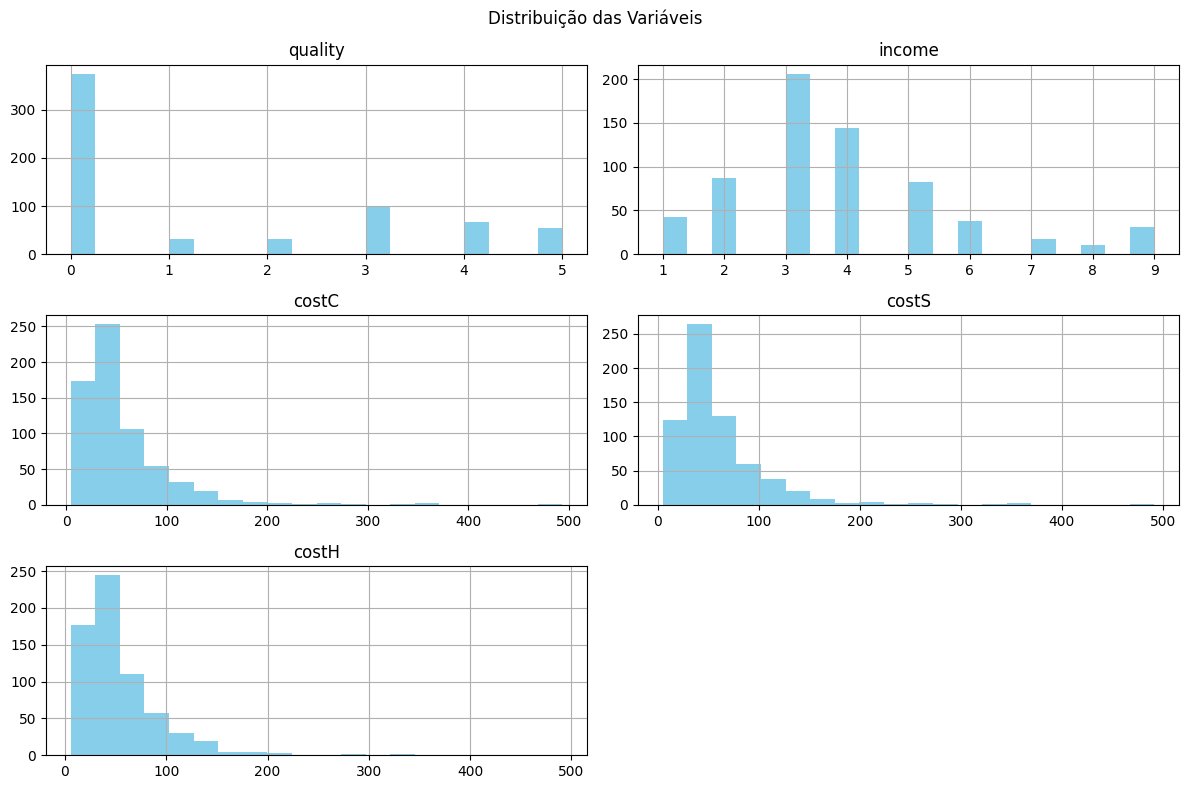

In [10]:
df.drop(columns='trips').hist(bins=20, figsize=(12, 8), color='skyblue')
plt.suptitle("Distribuição das Variáveis")
plt.tight_layout()
plt.show()

#plt.savefig('./images/variables_distribution.png')

Agora, vamos exibir a correlação entre as variáveis da base de dados.

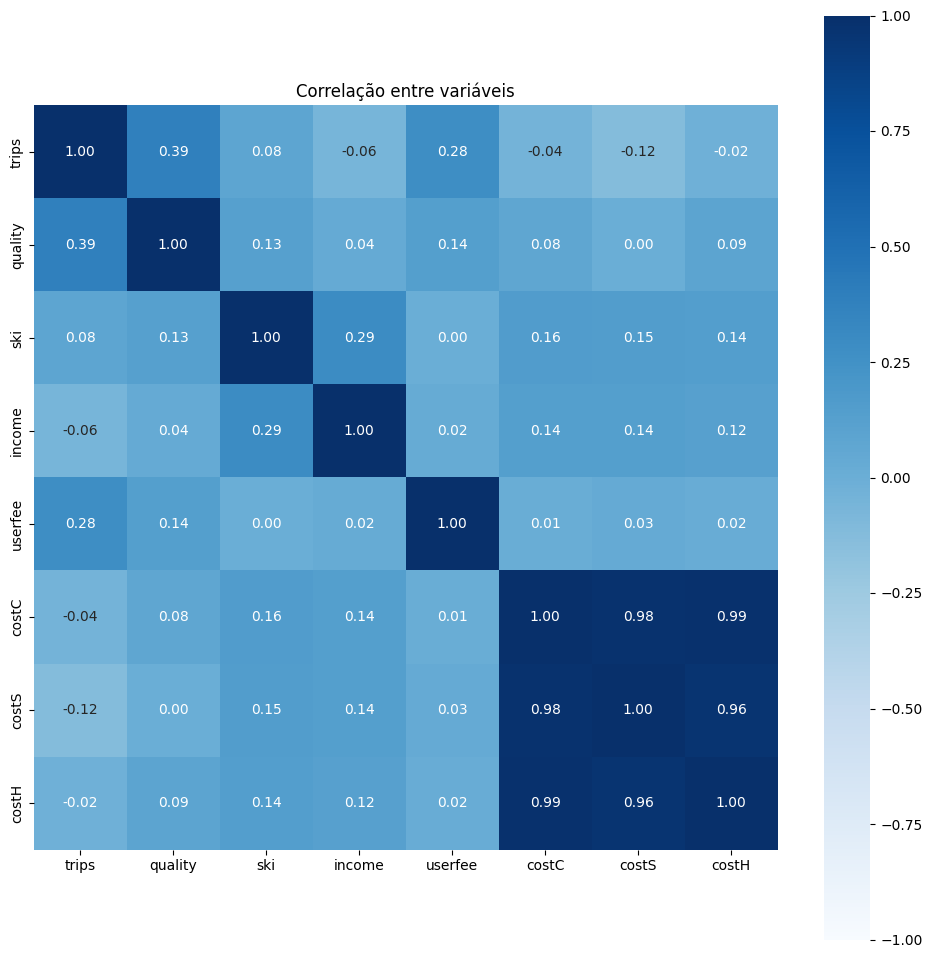

In [11]:
corr = associations(df, filename=None, fmt='.2f', cmap='Blues', figsize=(12,12),
                    title='Correlação entre variáveis')

A maior correlação com a variável `trips` é a coluna `quality` ($0.39$), o que mostra que uma avaliação mais alta da qualidade das instalações provavelmente leva a mais viagens. Em seguida é com a covariavel `userfee` ($0.28$), o que também faz sentido dado que, se aquele usuário paga a taxa de uso do lago, ele irá fazer mais visitas do que os usuários que não pagam.

As covariáveis de custo da visita aos diferentes lagos tem alta correlação entre si pois são custos muito similares.

### Quality

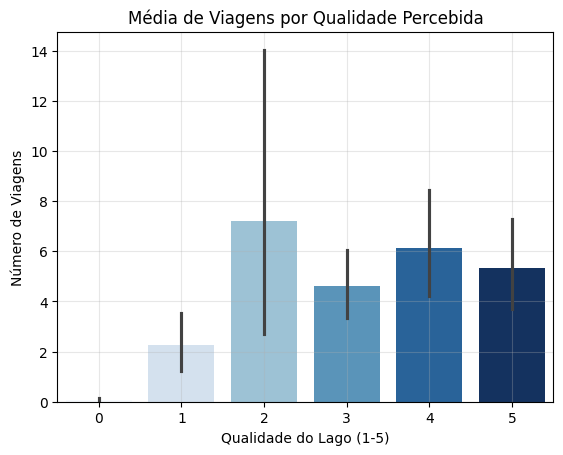

In [12]:
sns.barplot(x='quality', y='trips', data=df, palette='Blues', hue='quality')
plt.title('Média de Viagens por Qualidade Percebida')
plt.xlabel('Qualidade do Lago (1-5)')
plt.ylabel('Número de Viagens')
plt.grid(alpha=0.3)
plt.legend([],[], frameon=False)
plt.show()

#plt.savefig('./images/trips_quality.png')

In [13]:
df.groupby('quality')['trips'].agg(['mean', 'var', 'count']).reset_index().rename(columns={'mean': 'Média', 'var': 'Variância', 'count': 'Contagem'})

,quality,Média,Variância,Contagem
0,0,0.050802,0.643525,374
1,1,2.250000,11.290323,32
2,2,7.193548,288.627957,31
3,3,4.633663,44.514455,101
4,4,6.119403,81.227951,67
5,5,5.314815,44.182041,54


### Userfee

In [14]:
fig = px.box(
    df,
    x='userfee',
    y='trips',
    title='Número de Viagens por Taxa de Uso <br><sup>Escala logarítmica no eixo Y para melhor visualização</sup>',
    labels={'userfee': 'Pagamento da Taxa de Uso', 'trips': 'Número de Viagens'},
    color='userfee',
    color_discrete_sequence=px.colors.qualitative.Set1 
)

# Log scale no eixo Y
fig.update_yaxes(type='log')

fig.update_layout(
    showlegend=False,
    plot_bgcolor='white',
    title_font=dict(color='black'),
    width=600,
    height=420,
    yaxis=dict(showgrid=True, gridcolor='rgba(200, 200, 200, 0.3)', gridwidth=1),
)

fig.show()

# Exportar imagem
fig.write_image('./images/boxplot_taxa.png')


In [15]:
df.groupby('userfee')['trips'].agg(['mean', 'var', 'count']).reset_index().rename(columns={'mean': 'Média', 'var': 'Variância', 'count': 'Contagem'})

,userfee,Média,Variância,Contagem
0,no,1.995356,34.565870,646
1,yes,14.615385,144.089744,13


### Ski

In [16]:
fig = px.box(
    df,
    x='ski',
    y='trips',
    title='Distribuição de Viagens por Prática de Esqui <br><sup>Escala logarítmica no eixo Y para melhor visualização</sup>',
    labels={'ski': 'Prática de Esqui', 'trips': 'Número de Viagens'},
    color='ski',
    color_discrete_sequence=px.colors.qualitative.Set1,
    category_orders={'ski': ['no', 'yes']} 
)

# Log scale no eixo Y
fig.update_yaxes(type='log')

fig.update_layout(
    showlegend=False,
    plot_bgcolor='white',
    width=500,
    height=400,
    yaxis=dict(showgrid=True, gridcolor='rgba(200, 200, 200, 0.3)', gridwidth=1),
)

fig.show()

# Exportar imagem
fig.write_image('./images/boxplot_ski.png')


In [17]:
df.groupby('ski')['trips'].agg(['mean', 'var', 'count']).reset_index().rename(columns={'mean': 'Média', 'var': 'Variância', 'count': 'Contagem'})

,ski,Média,Variância,Contagem
0,no,1.865707,34.332884,417
1,yes,2.896694,48.167707,242


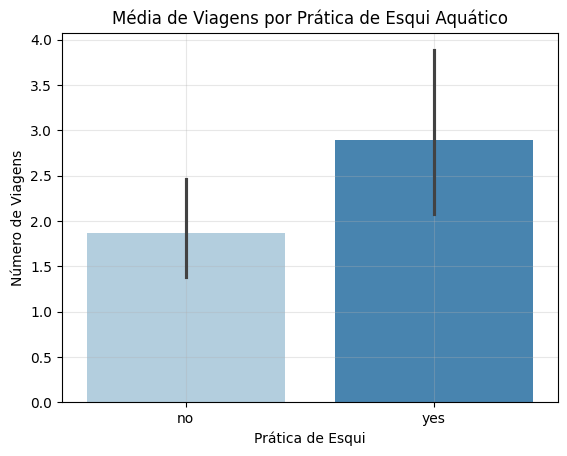

<Figure size 640x480 with 0 Axes>

In [18]:
sns.barplot(x='ski', y='trips', data=df, palette='Blues', hue='ski')
plt.title('Média de Viagens por Prática de Esqui Aquático')
plt.xlabel('Prática de Esqui')
plt.ylabel('Número de Viagens')
plt.grid(alpha=0.3)
plt.legend([],[], frameon=False)
plt.show()

plt.savefig('./images/bars_ski.png')

### Income

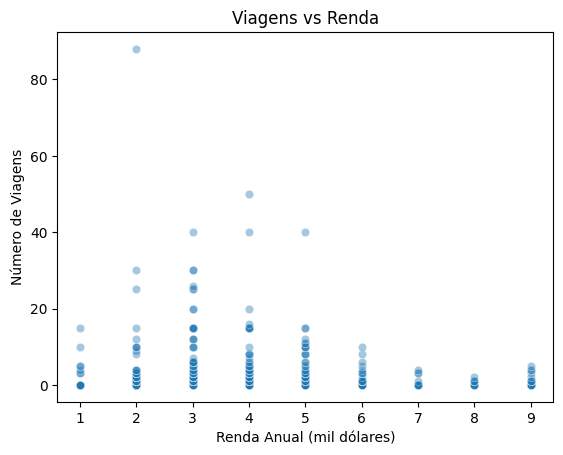

In [19]:
sns.scatterplot(
    data=df,
    x='income',
    y='trips',
    alpha=0.4
)
plt.title('Viagens vs Renda')
plt.xlabel('Renda Anual (mil dólares)')
plt.ylabel('Número de Viagens')
plt.show()

#plt.savefig('./images/scatter_income_trips.png')

### CostC, CostS e CostH

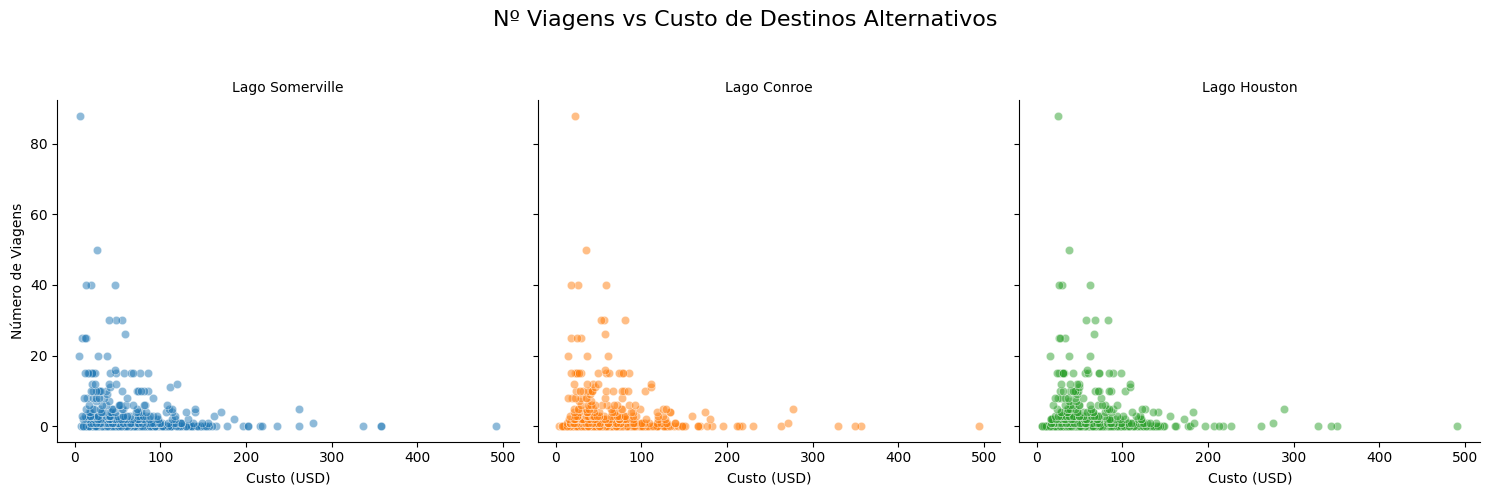

In [20]:
df_melted = df.melt(
    id_vars=['trips'],
    value_vars=['costS', 'costC', 'costH'],
    var_name='Custo_Destino',
    value_name='Custo'
)

df_melted['Custo_Destino'] = df_melted['Custo_Destino'].map({
    'costS': 'Lago Somerville',
    'costC': 'Lago Conroe',
    'costH': 'Lago Houston'
})

g = sns.FacetGrid(df_melted, col='Custo_Destino', height=5, aspect=1, hue='Custo_Destino',)
g.map(sns.scatterplot, 'Custo', 'trips', alpha=0.5)
g.set_axis_labels('Custo (USD)', 'Número de Viagens')
g.set_titles(col_template='{col_name}')
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Nº Viagens vs Custo de Destinos Alternativos', fontsize=16)
plt.show()

#plt.savefig('./images/scatter_cost_destinations.png')